# An Efficient Deep Learning Method for Detection of COVID-19 Infection Using Chest X-ray Images

The proposed automated framework to classify COVID-19 infection cases from normal and pneumonia using CXR images are depicted in Figure 2. The framework consists of two stages:
- (i) prepossessing which includes image enhancement, data augmentation, and image normalization
- (ii) classification using the proposed light-weight CNN model (LW-CORONet).

# Pre-Processing
Image enhancement is frequently used in the biomedical image processing domain to improve image quality [38,39]. Therefore, in this study, we performed the image enhancement by employing bilinear interpolation (BI) followed by the contrast- limited adaptive histogram equalization (CLAHE) technique. Initially, BI was applied to replace the missing pixel by computing a weighted average of the nearest boundary pixels [40]. Then, CLAHE was employed for contrast enhancement that prevents over- enhancement of noise present in the images [41,42], thereby, facilitating better diagnosis. Figure 3 depicts the outcomes of the preprocessing stage (BI and CLAHE).

# Load Model

In [1]:
from LwCoronNet import *
from PIL import Image
import torch
from torchvision import transforms
from LwCoronNet import *
from sklearn import metrics

In [4]:
# Funzione per caricare e classificare una singola immagine
def classify_single_image(image_path, model, transform, device, class_names):
    # Carica l'immagine
    image = Image.open(image_path).convert('RGB')  # Converte in RGB nel caso sia in scala di grigi

    # Applica le trasformazioni
    input_tensor = transform(image).unsqueeze(0)  # Aggiungi una dimensione batch

    # Sposta su dispositivo (GPU o CPU)
    input_tensor = input_tensor.to(device)

    # Disabilita il calcolo dei gradienti per inferenza
    with torch.no_grad():
        # Passa l'immagine attraverso il modello
        output = model(input_tensor)

        # Ottieni la classe con la massima probabilità
        _, predicted_class = torch.max(output, 1)

    # Restituisci il nome della classe predetta
    return class_names[predicted_class.item()]


def create_confusion_matrix(path_to_test, transform, dataset_sampling, classes=None):
    if classes is None:
        classes = ['COVID19', 'NORMAL', 'PNEUMONIA']
    test_dataset = datasets.ImageFolder(path_to_test, transform=transform)
    testLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # iterate over test data
    for inputs, labels in testLoader:
            #inputs = transform(inputs).unsqueeze(0)
            inputs = inputs.to(device)

            # Disabilita il calcolo dei gradienti per inferenza
            with torch.no_grad():
                # Passa l'immagine attraverso il modello
                output = model(inputs)

                # Ottieni la classe con la massima probabilità
                _, predicted_class = torch.max(output, 1)

            y_pred.extend(predicted_class) # Save Prediction

            y_true.extend(labels) # Save Truth

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()
    plt.savefig(f'CM_LwCoronNet{dataset_sampling}.png')
    return y_true, y_pred

In [5]:
# Definisci il percorso dell'immagine
image_path = "./Data/test/COVID19/COVID19(575).jpg"
image_path = "./Data/test/NORMAL/NORMAL(1552).jpg"
#image_path = "./Data/test/PNEUMONIA/PNEUMONIA(3418).jpg"

# Assumiamo che il dataset abbia già una lista di nomi di classi
class_names = ['COVID19', 'NORMAL', 'PNEUMONIA']#test_dataset.classes  # Sostituisci con la tua lista di classi
H,W = 224, 224
# Definisci le trasformazioni necessarie (assicurati siano le stesse usate durante il training)
transform_single = transforms.Compose([
    transforms.Resize((H, W)),  # Dimensioni d'ingresso del modello
    transforms.ToTensor(),
])

model = LwCoronNet()
dataset_sampling = '_undersampling'
n_model = os.listdir(os.path.join(".",f"training_results{dataset_sampling}"))
model_path = os.path.join(".",f"training_results{dataset_sampling}",f"model_epoch_{20}.pth")
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()
device = "cpu"

# Classifica l'immagine
predicted_label = classify_single_image(image_path, model, transform_single, device, class_names)
print(f"Predicted Label: {predicted_label}")


Predicted Label: NORMAL


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


# Valutazioni delle prestazioni sul dataset di Test

In [44]:
from sklearn import metrics

def create_confusion_matrix(model, device, path_to_test, transform, batch_size, data_sampling=''):
    classes = ['COVID19', 'NORMAL', 'PNEUMONIA']
    y_pred = []
    y_true = []

    test_dataset = datasets.ImageFolder(path_to_test, transform=transform)
    testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # iterate over test data
    for inputs, labels in testLoader:
            #inputs = transform(inputs).unsqueeze(0)
            inputs = inputs.to(device)

            # Disabilita il calcolo dei gradienti per inferenza
            with torch.no_grad():
                # Passa l'immagine attraverso il modello
                output = model(inputs)

                # Ottieni la classe con la massima probabilità
                _, predicted_class = torch.max(output, 1)

            y_pred.extend(predicted_class) # Save Prediction

            y_true.extend(labels) # Save Truth

    # constant for classes

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
    cm_display.plot(cmap=plt.cm.Blues)

    plt.savefig(f'CM_LwCoronNet{data_sampling}.png')

    return y_pred, y_true

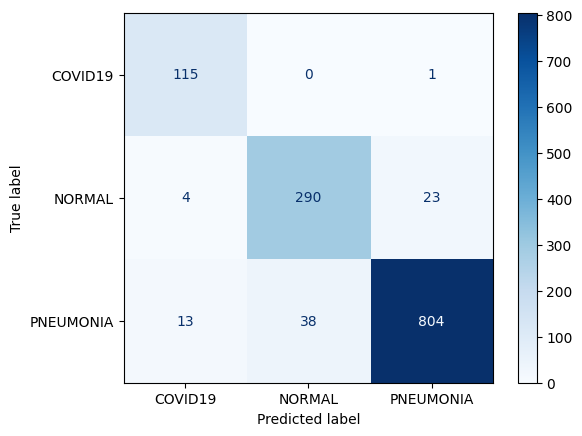

In [45]:
path_to_test = os.path.join(".", "Data", "test")
transform_DL = transforms.Compose([
    transforms.Resize((H,W)),
    transforms.ToTensor()
])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1)),
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_gaussian_noise(x) if torch.rand(1).item() > 0.5 else x),
])

model = LwCoronNet()
dataset_sampling = '_undersampling'
n_model = max([int(x.replace('model_epoch_','').replace('.pth','')) for x in os.listdir(os.path.join(".",f"training_results{dataset_sampling}")) if 'pth' in x])
model_path = os.path.join(".",f"training_results{dataset_sampling}",f"model_epoch_{n_model}.pth")
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()
device = "cpu"

y_pred_undersampling, y_true_undersampling = create_confusion_matrix(model, device, path_to_test, transform_DL, BATCH_SIZE, data_sampling=dataset_sampling)

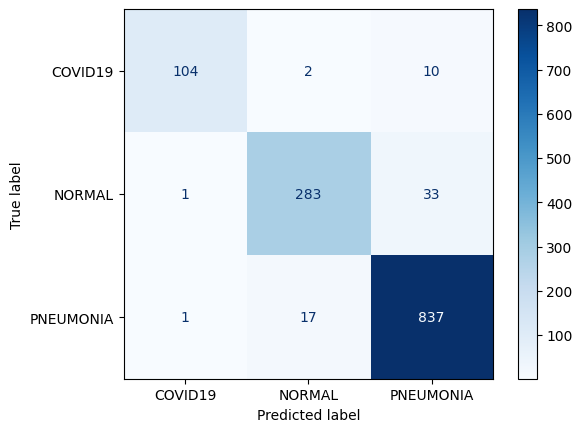

In [46]:
model = LwCoronNet()
dataset_sampling = ''
n_model = max([int(x.replace('model_epoch_','').replace('.pth','')) for x in os.listdir(os.path.join(".",f"training_results{dataset_sampling}")) if 'pth' in x])
model_path = os.path.join(".",f"training_results{dataset_sampling}",f"model_epoch_{n_model}.pth")
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()
device = "cpu"

y_pred, y_true = create_confusion_matrix(model, device, path_to_test, transform_DL, BATCH_SIZE, data_sampling=dataset_sampling)

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=['COVID19', 'PNEUMONIA', 'NORMAL']))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

     COVID19       0.98      0.90      0.94       116
   PNEUMONIA       0.94      0.89      0.91       317
      NORMAL       0.95      0.98      0.96       855

    accuracy                           0.95      1288
   macro avg       0.96      0.92      0.94      1288
weighted avg       0.95      0.95      0.95      1288

[[104   2  10]
 [  1 283  33]
 [  1  17 837]]


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true_undersampling, y_pred_undersampling, target_names=['COVID19', 'PNEUMONIA', 'NORMAL']))
print(confusion_matrix(y_true_undersampling, y_pred_undersampling))


              precision    recall  f1-score   support

     COVID19       0.87      0.99      0.93       116
   PNEUMONIA       0.88      0.91      0.90       317
      NORMAL       0.97      0.94      0.96       855

    accuracy                           0.94      1288
   macro avg       0.91      0.95      0.93      1288
weighted avg       0.94      0.94      0.94      1288

[[115   0   1]
 [  4 290  23]
 [ 13  38 804]]


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precisione media ponderata (weighted)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"precision: {precision},\nrecall: {recall},\nf1: {f1}")

precision: 0.9503798160361309,
recall: 0.9503105590062112,
f1: 0.9499083860021661
